# BERT

In [2]:
import math
import re
from random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
# Set GPU device
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# os.environ['http_proxy']  = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# torch.cuda.get_device_name(0)

cuda


## 1. Data

In [4]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')

# mount with os
import os
os.chdir('/content/drive/My Drive/_NLP/A4/NLP-A4-Do-You-Agree')

Mounted at /content/drive


In [5]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.7 MB/s eta 0:00:00


In [6]:
from datasets import load_dataset

# Load BookCorpus dataset
# The first 1% of `train` split.
# dataset = load_dataset('bookcorpus', split='train[:100000]')
# dataset

# Save to Parquet (to avoid time consuming for next time )
#dataset.to_parquet("data/bookcorpus_100k.parquet")

# Load from Parquet (Fastest)
dataset = load_dataset("parquet", data_files="data/bookcorpus_100k.parquet")
dataset = dataset["train"]

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
dataset

Dataset({
    features: ['text'],
    num_rows: 100000
})

## 2. Preprocessing

### Tokenization and numericalization

In [8]:
sentences = dataset['text']
text = [x.lower() for x in sentences] #lower case
text = [re.sub("[.,!?\\-]", '', x) for x in text] #clean all symbols
# text

In [9]:
for sentence in text:
    print(sentence, "_____")
    words = sentence.split()
    print(words)
    break

usually  he would be tearing around the living room  playing with his toys  _____
['usually', 'he', 'would', 'be', 'tearing', 'around', 'the', 'living', 'room', 'playing', 'with', 'his', 'toys']


In [10]:
from tqdm.auto import tqdm

# combine everything into one to make vocabs
word_list = list(set(" ".join(text).split()))
word2id = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3, '[UNK]': 4}  #special tokens.

#create the word2id
for i, w in enumerate(word_list):
    word2id[w] = i + 5  #because 0-3 are already occupied
    id2word = {i: w for i, w in enumerate(word2id)}
    vocab_size = len(word2id)
print(f'Vocab size : {vocab_size}')

#list of all tokens for whole text
token_list = list()
for sentence in text:
    arr = [word2id[word] for word in sentence.split()]
    token_list.append(arr)

Vocab size : 23069


In [11]:
vocab_size = len(word2id)

# List of all tokens for the whole text
token_list = []

# Process sentences more efficiently
for sentence in tqdm(text, desc="Processing sentences"):
    token_list.append([word2id[word] for word in sentence.split()])

# Now token_list contains the tokenized sentences

Processing sentences:   0%|          | 0/100000 [00:00<?, ?it/s]

In [12]:
#take a look at sentences
sentences[:2]

['usually , he would be tearing around the living room , playing with his toys .',
 'but just one look at a minion sent him practically catatonic .']

In [13]:
#take a look at token_list
token_list[:2]

[[2571,
  7874,
  5816,
  8028,
  4115,
  4612,
  18585,
  8543,
  5758,
  13552,
  22311,
  21605,
  4534],
 [2961, 18702, 19987, 19949, 19946, 15967, 18466, 8257, 10366, 7728, 20381]]

In [14]:
#testing one sentence
for tokens in token_list[0]:
    print(id2word[tokens])

usually
he
would
be
tearing
around
the
living
room
playing
with
his
toys


In [15]:
# import spacy
# import re

# # Load spaCy model
# nlp = spacy.load("en_core_web_sm")

# # Extract text from training dataset
# texts = train_data["text"]  # Assuming train_data is a Hugging Face dataset

# # Tokenize sentences using spaCy
# sentences = []
# for text in texts:
#     doc = nlp(text)
#     sentences.extend([sent.text.lower() for sent in doc.sents])  # Lowercasing

# # Clean sentences (remove punctuation)
# clean_sentences = [re.sub(r"[.,!?\\-]", "", sentence) for sentence in sentences]

# # Initialize vocabulary with special tokens
# word2id = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}

# # Create vocabulary from text
# word_list = list(set(" ".join(clean_sentences).split()))

# # Assign unique IDs to words (starting from 4)
# for i, w in enumerate(word_list):
#     word2id[w] = i + 4

# # Reverse dictionary (ID to word mapping)
# id2word = {i: w for w, i in word2id.items()}
# vocab_size = len(word2id)

# # Convert sentences into tokenized ID lists
# token_list = []
# for sentence in clean_sentences:
#     tokenized_sentence = [word2id[word] for word in sentence.split() if word in word2id]
#     tokenized_sentence = [word2id["[CLS]"]] + tokenized_sentence + [word2id["[SEP]"]]  # Add CLS and SEP tokens
#     token_list.append(tokenized_sentence)

# # Print samples
# print("Vocabulary Size:", vocab_size)
# print("Sample Tokenized Sentence:", token_list[0])


## 3. Data loader

We gonna make dataloader.  Inside here, we need to make two types of embeddings: **token embedding** and **segment embedding**

1. **Token embedding** - Given “The cat is walking. The dog is barking”, we add [CLS] and [SEP] >> “[CLS] the cat is walking [SEP] the dog is barking”.

2. **Segment embedding**
A segment embedding separates two sentences, i.e., [0 0 0 0 1 1 1 1 ]

3. **Masking**
As mentioned in the original paper, BERT randomly assigns masks to 15% of the sequence. In this 15%, 80% is replaced with masks, while 10% is replaced with random tokens, and the rest 10% is left as is.  Here we specified `max_pred`

4. **Padding**
Once we mask, we will add padding. For simplicity, here we padded until some specified `max_len`.

Note:  `positive` and `negative` are just simply counts to keep track of the batch size.  `positive` refers to two sentences that are really next to one another.

In [16]:
batch_size = 6
max_mask   = 5 #even though it does not reach 15% yet....maybe you can set this threshold
max_len    = 1000 #maximum length that my transformer will accept.....all sentence will be padded

In [17]:
def make_batch():
    batch = []
    positive = negative = 0
    while positive != batch_size / 2 or negative != batch_size / 2:

        #randomly choose two sentence
        tokens_a_index, tokens_b_index = randrange(len(sentences)), randrange(len(sentences))
        tokens_a, tokens_b            = token_list[tokens_a_index], token_list[tokens_b_index]

        #1. token embedding - add CLS and SEP
        input_ids = [word2id['[CLS]']] + tokens_a + [word2id['[SEP]']] + tokens_b + [word2id['[SEP]']]

        #2. segment embedding - which sentence is 0 and 1
        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        #3 masking
        n_pred = min(max_mask, max(1, int(round(len(input_ids) * 0.15))))
        #get all the pos excluding CLS and SEP
        candidates_masked_pos = [i for i, token in enumerate(input_ids) if token != word2id['[CLS]']
                                 and token != word2id['[SEP]']]
        shuffle(candidates_masked_pos)
        masked_tokens, masked_pos = [], []
        #simply loop and mask accordingly
        for pos in candidates_masked_pos[:n_pred]:
            masked_pos.append(pos)
            masked_tokens.append(input_ids[pos])
            if random() < 0.1:  #10% replace with random token
                index = randint(0, vocab_size - 1)
                input_ids[pos] = word2id[id2word[index]]
            elif random() < 0.8:  #80 replace with [MASK]
                input_ids[pos] = word2id['[MASK]']
            else:
                pass

        #4. pad the sentence to the max length
        n_pad = max_len - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        #5. pad the mask tokens to the max length
        if max_mask > n_pred:
            n_pad = max_mask - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        #6. check whether is positive or negative
        if tokens_a_index + 1 == tokens_b_index and positive < batch_size / 2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True])
            positive += 1
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size / 2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False])
            negative += 1

    return batch


In [18]:
batch = make_batch()

In [19]:
len(batch)

6

In [20]:
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

In [21]:
input_ids.shape, segment_ids.shape, masked_tokens.shape, masked_pos.shape, isNext

(torch.Size([6, 1000]),
 torch.Size([6, 1000]),
 torch.Size([6, 5]),
 torch.Size([6, 5]),
 tensor([0, 0, 0, 1, 1, 1]))

In [22]:
masked_tokens

tensor([[ 7106, 18590,  7679,     0,     0],
        [10276, 18585, 22986, 10366,  4555],
        [18585,  3179, 11975, 21017, 15301],
        [ 4335, 18585,  6705,  6468,  8084],
        [20598, 11823, 19599, 14142,     0],
        [ 9058, 11823,     0,     0,     0]])

## 4. Model

Recall that BERT only uses the encoder.

BERT has the following components:

- Embedding layers
- Attention Mask
- Encoder layer
- Multi-head attention
- Scaled dot product attention
- Position-wise feed-forward network
- BERT (assembling all the components)

## 4.1 Embedding

In [23]:
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(max_len, d_model)      # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)
        self.device = device

    def forward(self, x, seg):
        #x, seg: (bs, len)
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long).to(self.device)
        #pos = torch.arange(seq_len, dtype=torch.long)
        pos = pos.unsqueeze(0).expand_as(x)  # (len,) -> (bs, len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

## 4.2 Attention mask

In [24]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

### Testing the attention mask

In [25]:
print(get_attn_pad_mask(input_ids, input_ids).shape)

torch.Size([6, 1000, 1000])


## 4.3 Encoder

The encoder has two main components:

- Multi-head Attention
- Position-wise feed-forward network

First let's make the wrapper called `EncoderLayer`

In [26]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn       = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

Let's define the scaled dot attention, to be used inside the multihead attention

In [27]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

Let's define the parameters first

Here is the Multiheadattention.

In [28]:
# class MultiHeadAttention(nn.Module):
#     def __init__(self):
#         super(MultiHeadAttention, self).__init__()
#         self.W_Q = nn.Linear(d_model, d_k * n_heads).to(device)
#         self.W_K = nn.Linear(d_model, d_k * n_heads).to(device)
#         self.W_V = nn.Linear(d_model, d_v * n_heads).to(device)
#     def forward(self, Q, K, V, attn_mask):
#         # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
#         residual, batch_size = Q, Q.size(0)
#         # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
#         q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
#         k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
#         v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

#         attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1).to(device) # attn_mask : [batch_size x n_heads x len_q x len_k]

#         # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
#         context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
#         context = context.transpose(1, 2).contiguousdview(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
#         output = nn.Linear(n_heads * d_v, d_model).to(device)(context)
#         return nn.LayerNorm(d_model).to(device)(output + residual), attn # output: [batch_size x len_q x d_model]

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads).to(device)
        self.W_K = nn.Linear(d_model, d_k * n_heads).to(device)
        self.W_V = nn.Linear(d_model, d_v * n_heads).to(device)

    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1, 2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1, 2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1, 2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1).to(device)  # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v)
        output = nn.Linear(n_heads * d_v, d_model).to(device)(context)
        return nn.LayerNorm(d_model).to(device)(output + residual), attn  # output: [batch_size x len_q x d_model]

In [29]:
n_layers = 6    # number of Encoder of Encoder Layer
n_heads  = 8    # number of heads in Multi-Head Attention
d_model  = 768  # Embedding Size
d_ff = 768 * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2

Here is the PoswiseFeedForwardNet.

In [30]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(F.gelu(self.fc1(x)))


## 4.4 Putting them together

In [31]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.embedding = Embedding().to(device)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model).to(device)
        self.activ = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model).to(device)
        self.norm = nn.LayerNorm(d_model).to(device)
        self.classifier = nn.Linear(d_model, 2).to(device)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False).to(device)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab)).to(device)

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]

        # 1. predict next sentence
        # it will be decided by first token(CLS)
        h_pooled   = self.activ(self.fc(output[:, 0])) # [batch_size, d_model]
        logits_nsp = self.classifier(h_pooled) # [batch_size, 2]

        # 2. predict the masked token
        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked  = self.norm(F.gelu(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_nsp

## 5. Training

In [32]:
num_epoch = 300
model = BERT()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = []

model = model.to(device)
batch = make_batch()
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))
# Move inputs to GPU
input_ids = input_ids.to(device)
segment_ids = segment_ids.to(device)
masked_tokens = masked_tokens.to(device)
masked_pos = masked_pos.to(device)
isNext = isNext.to(device)


for epoch in range(num_epoch):
    optimizer.zero_grad()
    logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)
    #logits_lm: (bs, max_mask, vocab_size) ==> (6, 5, 34)
    #logits_nsp: (bs, yes/no) ==> (6, 2)

    #1. mlm loss
    #logits_lm.transpose: (bs, vocab_size, max_mask) vs. masked_tokens: (bs, max_mask)
    loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
    loss_lm = (loss_lm.float()).mean()
    #2. nsp loss
    #logits_nsp: (bs, 2) vs. isNext: (bs, )
    loss_nsp = criterion(logits_nsp, isNext) # for sentence classification

    #3. combine loss
    loss = loss_lm + loss_nsp
    train_losses.append(loss)
    if epoch % 100 == 0:
        print('Epoch:', '%02d' % (epoch), 'loss =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

Epoch: 00 loss = 104.709999
Epoch: 100 loss = 5.166832
Epoch: 200 loss = 3.920063


In [33]:
import matplotlib.pyplot as plt

def plot_losses(losses):
    # Transfer tensor data from GPU to CPU
    losses = [loss.item() for loss in losses]

    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

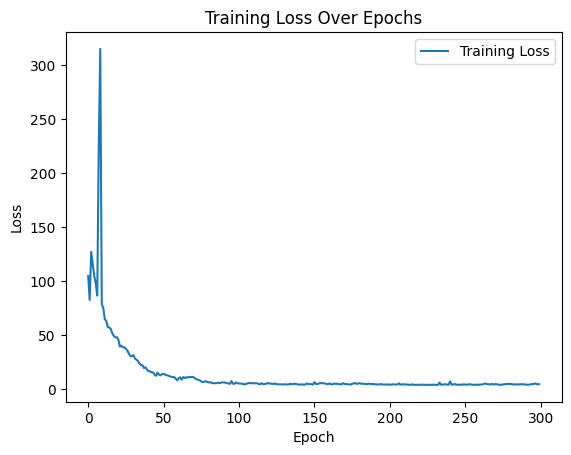

In [39]:
plot_losses(train_losses)

## 6. Inference

Since our dataset is very small, it won't work very well, but just for the sake of demonstration.

In [46]:
device

device(type='cuda')

In [50]:
# Predict mask tokens ans isNext
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(batch[2]))
print([id2word[w.item()] for w in input_ids[0] if id2word[w.item()] != '[PAD]'])

# Move inputs to GPU
input_ids = input_ids.to(device)
segment_ids = segment_ids.to(device)
masked_tokens = masked_tokens.to(device)
masked_pos = masked_pos.to(device)
isNext = isNext.to(device)

logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)
#logits_lm:  (1, max_mask, vocab_size) ==> (1, 5, 34)
#logits_nsp: (1, yes/no) ==> (1, 2)

#predict masked tokens
#max the probability along the vocab dim (2), [1] is the indices of the max, and [0] is the first value
#logits_lm = logits_lm.data.max(2)[1][0].data.numpy()
logits_lm = logits_lm.data.max(2)[1][0].cpu().data.numpy() # Move the tensor to CPU using .cpu()
#note that zero is padding we add to the masked_tokens
print('masked tokens (words) : ',[id2word[pos.item()] for pos in masked_tokens[0]])
print('masked tokens list : ',[pos.item() for pos in masked_tokens[0]])
print('masked tokens (words) : ',[id2word[pos.item()] for pos in logits_lm])
print('predict masked tokens list : ', [pos for pos in logits_lm])

#predict nsp
# Move the tensor to CPU before converting to NumPy
logits_nsp = logits_nsp.data.max(1)[1][0].cpu().data.numpy()
print(logits_nsp)
print('isNext : ', True if isNext else False)
print('predict isNext : ',True if logits_nsp else False)

['[CLS]', 'he', 'knew', 'her', 'sisterinlaw', '[MASK]', 'reaction', 'still', 'upset', 'her', 'but', 'she', 'was', 'able', 'to', 'see', 'the', 'funny', '[MASK]', 'of', '[MASK]', 'all', 'too', '[SEP]', 'it', 'marvel', 'his', 'aura', 'his', 'confidence', '[SEP]']
masked tokens (words) :  ['her', 'side', 'it', 'was', "'s"]
masked tokens list :  [15673, 8214, 9570, 10276, 17141]
masked tokens (words) :  ['nice', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
predict masked tokens list :  [12045, 0, 0, 0, 0]
1
isNext :  False
predict isNext :  True


Trying a bigger dataset should be able to see the difference.

In [51]:
save_path = f'./app/models/bert-pretrained-model.pt'
torch.save(model.state_dict(), save_path)

In [52]:
data = {}
data['vocab_size'] = vocab_size
data['word2id'] = word2id

data['batch_size'] = batch_size
data['max_mask'] = max_mask
data['max_len'] = max_len

data['n_layers'] = n_layers
data['n_heads'] = n_heads
data['d_model'] = d_model
data['d_ff'] = d_ff
data['d_k'] = d_k
data['d_v'] = d_v
data['n_segments'] = n_segments

In [2]:
# data

In [55]:
import pickle
pickle.dump(data, open('./app/models/bert-pretrained-data.pkl', 'wb'))